In [1]:
#!pip install --upgrade pip
#!pip install -U numpy
#!pip install gensim 
#!pip install spacy==2.0.10
#!pip install greenlet
#!pip install allennlp --user

In [2]:
# Torch, Sklearn imports
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

## AllenNLP
import allennlp
from allennlp.modules.elmo import Elmo, batch_to_ids
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM
from allennlp.modules.token_embedders import BertEmbedder

print("PyTorch: {}".format(torch.__version__))
print("AllenNLP: {}".format(allennlp.__version__))

PyTorch: 1.0.0
AllenNLP: 0.8.0


In [3]:
## NLP libs
from nltk import download
import gensim
from nltk.corpus import stopwords
download('stopwords')

## General libs
import numpy as np
import pandas as pd
from string import punctuation
import os, re, sys, json, requests, pickle

02/04/2019 14:39:34 - INFO - summarizer.preprocessing.cleaner -   'pattern' package not found; tag filters are not available for English


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rsilvei/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# Set data locations
bucket = 'adp-e-ml-notebooks-sagemaker'                        # replace this with your own bucket
prefix = 'vectors'   # replace this with your own prefix

elmo_weights_key = '{}/elmo_2x4096_512_2048cnn_2xhighway_5.5B_weights.hdf5'.format(prefix)
#elmo_weights_key = '{}/elmo_2x1024_128_2048cnn_1xhighway_weights.hdf5'.format(prefix)
elmo_weights_key_path = os.path.join('s3://', bucket, elmo_weights_key)

elmo_config_key = '{}/elmo_2x4096_512_2048cnn_2xhighway_5.5B_options.json'.format(prefix)
#elmo_config_key = '{}/elmo_2x1024_128_2048cnn_1xhighway_options.json'.format(prefix)
elmo_config_key_path = os.path.join('s3://', bucket, elmo_config_key)

### BERT Instance

#bert_type = 'bert-base-uncased'
#bert_model = BertModel.from_pretrained(bert_type)
#bert_embedder = BertEmbedder(bert_model, top_layer_only = True)
#bert_embedder = bert_embedder.cuda()

### Elmo Instance
elmo = Elmo(elmo_config_key_path, 
            elmo_weights_key_path, 
            num_output_representations = 1, 
            dropout=0.3,
            requires_grad = False)

02/04/2019 14:40:11 - INFO - allennlp.modules.elmo -   Initializing ELMo


In [6]:
#elmo.train()
elmo.eval()

# use batch_to_ids to convert sentences to character ids
sentences = [['First', 'sentence', '.', 'here'],
            ['First', 'sentence', '.'],
            ['First', 'sentence', 'second'],
            ['First', 'sentence', 'second'],
            ['First', 'sentence', 'right']]
character_ids = batch_to_ids(sentences)
elmo_embeddings = elmo(character_ids)
for i in range(len(sentences)):
    print("SENT {} - EMBED {}".format(sentences[i],elmo_embeddings['elmo_representations'][0][i].sum()))

SENT ['First', 'sentence', '.', 'here'] - EMBED 21.57114601135254
SENT ['First', 'sentence', '.'] - EMBED 7.291922569274902
SENT ['First', 'sentence', 'second'] - EMBED -19.64456558227539
SENT ['First', 'sentence', 'second'] - EMBED -19.64456558227539
SENT ['First', 'sentence', 'right'] - EMBED -26.144351959228516


In [7]:
elmo.get_output_dim()

1024

In [ ]:
## Get Bert Embeddings for same phrases
#bert_embeddings = bert_embedder(character_ids.cuda())
#for i in range(len(sentences)):
#    print("SENT {} - EMBED {}".format(sentences[i],bert_embeddings[i].sum()))
#bert_embeddings[0]
#rep = bert_embeddings[0].squeeze(dim=0)
#rep.shape
#avg = rep.mean(dim=0)
#avg.shape

## Processing Dataset

In [8]:
def transformText(text, do_stop=False, do_stem=False):
    stops = set(stopwords.words("english"))
    # Convert text to lower
    text = text.lower()
    
    # Cleaning input
    text = text.replace("'s","")
    text = text.replace("’s","")
    text = text.replace("?","")
    text = text.replace("-","")
    text = text.replace('"',"")
    
    # Removing non ASCII chars    
    text = re.sub(r'[^\x00-\x7f]',r' ',text)
    # Strip multiple whitespaces
    text = gensim.corpora.textcorpus.strip_multiple_whitespaces(text)
    # Removing all the stopwords
    if (do_stop==True):
        filtered_words = [word for word in text.split() if word not in stops]
    else:
        filtered_words = [word for word in text.split()]
    # Preprocessed text after stop words removal
    text = " ".join(filtered_words)
    # Remove the punctuation
    text = gensim.parsing.preprocessing.strip_punctuation2(text)
    # Strip multiple whitespaces
    text = gensim.corpora.textcorpus.strip_multiple_whitespaces(text)
    if (do_stem==True):
        # Stemming
        text = gensim.parsing.preprocessing.stem_text(text)
    return text

def strip_punctuation(s):
    return ''.join(c for c in s if c not in PUNCT)

## Lemmatization function based on Spacy Library
def lemmatizer_spacy(text):        
    sent = []
    doc = spacy_en(text)
    for word in doc:
        if word.lemma_ == "-PRON-":
            sent.append(word.text)
        else:
            sent.append(word.lemma_)
    return " ".join(sent)

def strip_punctuation(s):
    return ''.join(c for c in s if c not in punctuation)

In [9]:
dataset = pd.read_csv('intents.csv', sep=';')
dataset.rename(index=str, columns={"Intent": "intent", 
                                   "result": "phrases"},inplace=True)
dataset['clean_text']=dataset['phrases'].apply(lambda x: transformText(x))

## Augment dataset w/ more training phrases
dataset = pd.concat([dataset, dataset]).reset_index(drop=True)
## Suffle the dataset
dataset = dataset.sample(frac=1).reset_index(drop=True)
## Build word vocabulary
word_to_ix = {}
for sent in dataset.clean_text:
    for word in sent.split():
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
print("Tamanho do dicionario: {}".format(len(word_to_ix)))
## Build label vocabulary
label_to_ix = {}
for label in dataset.intent:
    for word in label.split():
        if word not in label_to_ix:
            label_to_ix[word]=len(label_to_ix)
print("Tamanho dos labels: {}".format(len(label_to_ix)))
data_split = int(0.8*len(dataset))
train_dataset = dataset[:data_split]
test_dataset = dataset[data_split:-1].reset_index(drop=True)

Tamanho do dicionario: 766
Tamanho dos labels: 169


In [10]:
len(label_to_ix)

169

In [11]:
dataset.tail(3)

,intent,phrases,clean_text
4951,position.update,"""position""",position
4952,band.create,"""make salary band""",make salary band
4953,compensationPlan.delete,"""remove bonus""",remove bonus


In [12]:
dataset.clean_text[0]

'make adjustments to job family'

In [13]:
def get_elmo(sent):
    elmo.eval()
    sent = [sent.split()]
    character_ids = batch_to_ids(sent)
    if torch.cuda.is_available():
        character_ids = character_ids.cuda()
    embeddings = elmo(character_ids)
    rep = embeddings['elmo_representations'][0]
    rep = rep.squeeze(dim=0)
    avg = rep.mean(dim=0)
    return avg

In [14]:
def get_elmo_batch(sent):
    character_ids = batch_to_ids(sent)
    if torch.cuda.is_available():
        character_ids = character_ids.cuda()
    embeddings = elmo(character_ids)
    rep = embeddings['elmo_representations'][0]
    #rep = rep.squeeze(dim=0)
    #avg = rep.mean(dim=0)
    #avg = x.mean(dim=0) for x in rep
    rep = rep.mean(dim=1)
    return rep

In [15]:
class Intents(Dataset):
    def __init__(self, dataframe, embed_type):
        self.len = len(dataframe)
        self.label_to_ix = {}
        self.data = dataframe
        self.embed_type = embed_type
        
    def __getitem__(self, index):
        phrase = self.data.clean_text[index]
        if self.embed_type == 'bert':
            X = get_features(phrase, max_seq_length, out_layers, zero_pad, include_special_tokens)
        elif self.embed_type == 'w2v':        
            X = get_avg_sentence_vector(phrase)
        elif self.embed_type == 'elmo':
            X = get_elmo(phrase)
        y = label_to_ix[self.data.intent[index]]
        return X, y
    
    def __len__(self):
        return self.len

In [16]:
training_set = Intents(train_dataset,"elmo")
testing_set = Intents(test_dataset, "elmo")

In [ ]:
torch.cuda.is_available()

## Simple MLP Classifier

In [ ]:
class MLPUncertainty(nn.Module):
    def __init__(self, inputdim, 
                        nclasses, 
                        nhidden, 
                        dropout = 0,
                        cudaEfficient=True,
                        decay = 1e-6):
        super(MLPUncertainty, self).__init__()
        """
        PARAMETERS:
        -dropout:    dropout for MLP
        """
        
        self.inputdim = inputdim
        self.hidden_dim = nhidden
        self.dropout = dropout
        self.decay = decay
        self.nclasses = nclasses
        
        if cudaEfficient:
            self.model = nn.Sequential(
                nn.Linear(self.inputdim, nhidden),
                nn.Dropout(p=self.dropout),
                nn.ReLU(),
                nn.Linear(nhidden, self.nclasses),
                ).cuda()
        else:
            self.model = nn.Sequential(
                nn.Linear(self.inputdim, nhidden),
                nn.Dropout(p=self.dropout),
                nn.ReLU(),
                nn.Linear(nhidden, self.nclasses),
                )
    def forward(self, x):
        log_probs = self.model(x)
        return log_probs

In [ ]:
elmo.get_output_dim()

In [ ]:
INP_DIM = elmo.get_output_dim()
NUM_LABELS = len(label_to_ix)
NHIDDEN = 1024
DROPOUT = 0.2
model = MLPUncertainty(inputdim = INP_DIM ,
              nhidden = NHIDDEN,
              nclasses = NUM_LABELS,
              dropout = DROPOUT, 
              cudaEfficient = True)
device = torch.device("cuda:0")
model = model.to(device)
model.cuda()

## Training

In [ ]:
# Dataloaders Parameters
params = {'batch_size': 10,
          'shuffle': True,
          'num_workers': 0}
training_loader = DataLoader(training_set, **params)
testing_loader = DataLoader(testing_set, **params)
# Hyperparams
loss_function = nn.CrossEntropyLoss()
learning_rate = 0.001 
optimizer = optim.Adam(params =  model.parameters(), lr=learning_rate)

In [ ]:
max_epochs = 5
for epoch in range(max_epochs):
    print("EPOCH -- {}".format(epoch))
    for i, (sent, label) in enumerate(training_loader):
        
        ## Step 1 - Clear gradients w.r.t. parameters
        optimizer.zero_grad()
        sent = Variable(sent.cuda())
        label = Variable(label.cuda())
        
        ## Step 2 - Run forward pass
        output = model.forward(sent)
        
        ## Step 3 - Compute loss
        loss = loss_function(output, label)
        loss.backward()
        
        ## Step 4 = Update parameters
        optimizer.step()
        if i%100 == 0:
            
            # Calculate Accuracy         
            correct = 0
            total = 0
            
            for sent, label in testing_loader:
                sent = Variable(sent.cuda())
                #sent = Variable(get_elmo_batch(sent))
                label = Variable(label.cuda())
                
                # Forward pass only to get logits/output
                output = model.forward(sent)
                
                # Get predictions from the maximum value
                _, predicted = torch.max(output.data, 1)
                
                # Total number of labels
                total += label.size(0)

                # Total correct predictions
                correct += (predicted.cpu() == label.cpu()).sum()
            accuracy = 100.00 * correct.numpy() / total
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}%'.format(i, loss.data, accuracy))

In [ ]:
def get_reply(phrase, model):
    x = get_elmo(phrase)
    #print(x)
    #print("ELMo value sum: {}".format(x.sum().cpu().data.numpy()))
    logits_out = model.forward(Variable(x))
    softmax_out = F.softmax(logits_out, dim=0)
    _, pred_label = torch.max(softmax_out.data, 0)
    prediction=list(label_to_ix.keys())[list(label_to_ix.values()).index(pred_label)]
    return prediction

In [ ]:
intent = "demote worker"
for i in range(0,10):
    print(get_reply(intent, model))

In [ ]:
model_version = 'third'
model_name = '{}_model.ckpt'.format(model_version)
dict_name = '{}_dict.pkl'.format(model_version)

In [ ]:
model_name, dict_name

In [ ]:
torch.save(model.state_dict(), model_name)

In [ ]:
def save_model_to_s3(model, model_name):
    import boto3
    s3 = boto3.client('s3')
    bucket_name = 'adp-e-ml-notebooks-sagemaker'
    prefix = 'training_data/elmo_intent/'
    torch.save(model.state_dict(), model_name)
    s3.upload_file(model_name, bucket_name, prefix + model_name)
    return "Done"

In [ ]:
def save_assets_to_s3(file, file_name):
    import boto3
    s3 = boto3.client('s3')
    bucket_name = 'adp-e-ml-notebooks-sagemaker'
    prefix = 'training_data/elmo_intent/'
    
    with open(file_name, 'wb') as f:
        pickle.dump((label_to_ix), f)
            
    s3.upload_file(file_name, bucket_name, prefix + file_name)
    return "Done"

In [ ]:
save_assets_to_s3(label_to_ix, dict_name)

In [ ]:
save_model_to_s3(model, model_name)

In [ ]:
## Test current model accuracy
with open('test_vector.pkl', 'rb') as f:
    test_sentences = pickle.load(f)

In [ ]:
test_sentences[0:5]

In [ ]:
correct = 0
total = 0
errors = []
for phrase, label in test_sentences:
    phrase_transformed = transformText(phrase)
    #print(phrase, "---", phrase_transformed)
    prediction = get_reply(phrase_transformed, model)
    total +=1
    if prediction == label:
        correct += 1
    else:
        errors.append((sent,label))
accuracy = 100.00 * correct / total

In [ ]:
accuracy

In [ ]:
#Introduce Augmentation in the Training Set

In [17]:
training_set.len

3963

['change', 'worker', 'birth']

In [179]:
sent = "change worker birth"
sent = sent.split()
character_ids = batch_to_ids(sent)
embeddings = elmo(character_ids)
rep = embeddings['elmo_representations'][0]

In [178]:
rep[0]

[tensor([[[-0.0453, -0.2557,  0.5382,  ...,  0.1851, -0.1954,  0.1156],
          [-0.3395,  0.1173,  0.2742,  ...,  0.1492, -0.3787,  0.2214],
          [-0.1287, -0.5378,  0.2778,  ..., -0.1781, -0.5354,  0.1932],
          [-0.3350, -0.0041,  0.3590,  ...,  0.3656, -0.4058,  0.2344],
          [-0.3380, -0.0022,  0.1417,  ...,  0.1077, -0.3672, -0.2522],
          [-0.1809,  0.1535,  0.4110,  ..., -0.4125, -0.2468,  0.0607]],
 
         [[-0.0349,  0.0844,  0.2538,  ...,  0.4148, -0.0919,  0.1439],
          [-0.2800,  0.4841,  0.4065,  ...,  0.3537, -0.6273, -0.0140],
          [-0.3242,  0.3064,  0.2050,  ...,  0.2319, -0.1859, -0.1851],
          [-0.2069,  0.0446,  0.2498,  ...,  0.4675, -0.2108,  0.2449],
          [-0.2549,  0.0260,  0.3208,  ..., -0.1134, -0.4484,  0.0830],
          [-0.1552, -0.0879,  0.3475,  ..., -0.1166, -0.0680,  0.0161]],
 
         [[-0.0316, -0.2266,  0.3107,  ...,  0.1340, -0.3838,  0.1449],
          [-0.1852, -0.3459,  0.6532,  ...,  0.1584, -0.36

In [26]:
rep[1].std()

tensor(0.3215, grad_fn=<StdBackward0>)

In [30]:
def add_gaussian(ins):
    mean = ins.mean()
    std = ins.std()
    noise = (ins.data.new(ins.size()).normal_(mean, std))
    print(noise)

In [33]:
rep.mean()

tensor(0.0103, grad_fn=<MeanBackward1>)

In [34]:
rep.std()

tensor(0.3104, grad_fn=<StdBackward0>)

In [40]:
from torch.distributions import normal

In [238]:
def get_phrase_dist(sent, n_points=100):
    elmo.eval()
    sent = sent.split()
    character_ids = batch_to_ids(sent)
    embeddings = elmo(character_ids)
    rep = embeddings['elmo_representations'][0]
    mean = rep.mean()
    std = rep.std()
    normal_sampler = normal.Normal(mean, std)
    sampling = torch.zeros(n_points)
    for i in range(len(sampling)):
        samp = normal_sampler.sample()
        sampling[i]=samp
    return sampling.numpy(), mean, std

In [239]:
get_phrase_dist("what is love")

(array([-0.21113814, -0.10238738,  0.08188599,  0.11394089,  0.3374219 ,
         0.03821812, -0.12858628, -0.39786413,  0.30626455,  0.05288905,
        -0.01446966, -0.06325083,  0.19489488,  0.12571537,  0.32905665,
        -0.2666206 , -0.13438399,  0.03366789, -0.18512967, -0.24832454,
        -0.10813254, -0.02548009, -0.26295698, -0.35741377, -0.1621948 ,
        -0.10096364,  0.09660107,  0.22522277, -0.02706377, -0.1591056 ,
        -0.20389192,  0.19725777,  0.1879761 , -0.11257292,  0.02180249,
        -0.13663734, -0.01487789,  0.08323882,  0.39123097,  0.09976273,
        -0.33656627, -0.07138523,  0.4562479 , -0.2555176 ,  0.17224656,
         0.18180566,  0.14374664,  0.23099282, -0.03983668,  0.09003624,
         0.12093793, -0.14747855,  0.21633363, -0.19345078, -0.08285982,
        -0.2125857 ,  0.02076558,  0.29544735, -0.02977327, -0.18187246,
        -0.19024023, -0.06434171, -0.24691641, -0.39079413, -0.05478676,
        -0.08125548,  0.225513  , -0.38184997, -0.1

In [389]:
n_sample = 8
list_intents_1 = list(dataset.clean_text[dataset.intent == "jobOffer.create"][0:n_sample])
list_intents_2 = list(dataset.clean_text[dataset.intent == "jobOffer.evaluate"][0:n_sample])
list_intents_3 = list(dataset.clean_text[dataset.intent == "demote"][0:n_sample])
list_intents_4 = list(dataset.clean_text[dataset.intent == "promote"][0:n_sample])
list_intents_5 = list(dataset.clean_text[dataset.intent == "jobReferral.evaluate"][0:n_sample])
list_intents_6 = list(dataset.clean_text[dataset.intent == "personMaritalStatus.update"][0:n_sample])
list_intents_7 = list(dataset.clean_text[dataset.intent == "personGender.update"][0:n_sample])

In [398]:
list_intents = {}
available_intents = ["promote", 
                     "demote",
                     "jobOffer.create", 
                     "jobReferral.evaluate",
                     "personMaritalStatus.update",
                     "personGender.update"]

In [399]:
for name in available_intents:
    phrases = list(dataset.clean_text[dataset.intent == name][0:n_sample])
    list_intents.update({name:phrases})

In [400]:
list_intents

{'demote': ['demote employee',
  'downgrade employee',
  'demote employee',
  'downgrade associate',
  'lower employee rank',
  'downgrade employee',
  'downgrade employee rank',
  'demote worker'],
 'jobOffer.create': ['please create new job offer',
  'can you make new job offer creation',
  'i need a new job offer to be created',
  'can you please create a new job offer',
  'let me create new job offer',
  'give me a new job offer',
  'creation of a new job offer',
  'let me create new job offer'],
 'jobReferral.evaluate': ['i need to recommend a job evaluation',
  'review job referral',
  'check job recommendation',
  'review job referral',
  'check job recommendation',
  'evaluate referral',
  'review job referral',
  'review employee referral'],
 'personGender.update': ['i am female',
  'change gender',
  'i m male',
  'i m a woman',
  'i m male',
  'modify my gender',
  'i am a man',
  'i prefer not to share my gender'],
 'personMaritalStatus.update': ['i m a widow',
  'i got div

In [243]:
def get_intent_mean_rep(list_intents):
    overall_rep = torch.zeros(len(list_intents))
    print(overall_rep.shape)
    for i in list_intents:
        elmo.eval()
        sent = i.split()
        character_ids = batch_to_ids(sent)
        embeddings = elmo(character_ids)
        rep = embeddings['elmo_representations'][0]
        mean = rep.mean()
        std = rep.std()
        print(rep)

In [244]:
get_intent_mean_rep(list_intents_1)

torch.Size([5])
tensor([[[-2.8060e-01, -1.5372e-01,  2.9022e-01,  ...,  7.1704e-02,
          -4.2041e-01,  2.1143e-01],
         [-6.5529e-02,  1.1269e-01,  1.9957e-01,  ...,  3.2801e-01,
          -5.0480e-01,  2.0520e-01],
         [-2.0302e-01,  1.3138e-01,  4.8695e-01,  ..., -4.1412e-02,
          -4.9168e-01,  2.5387e-01],
         [-1.4370e-01, -5.8003e-01,  2.4120e-01,  ..., -3.0468e-02,
          -5.8620e-01,  3.2771e-01],
         [-1.8802e-01, -4.3019e-01,  1.4141e-02,  ..., -8.9606e-02,
          -3.1013e-01,  4.1235e-01],
         [-1.7921e-01, -8.1047e-02,  2.0980e-01,  ..., -4.1287e-01,
          -2.4729e-01,  5.9494e-02]],

        [[-3.7957e-02, -2.4776e-01,  5.2971e-01,  ...,  1.8319e-01,
          -1.7906e-01,  2.1814e-01],
         [-3.8193e-01,  1.1554e-02,  4.0674e-01,  ...,  2.3949e-01,
          -1.4147e-01,  8.6067e-03],
         [-2.0473e-01, -1.6671e-02,  3.4843e-01,  ..., -1.9151e-01,
          -3.5425e-01,  2.1185e-01],
         [-1.1910e-01, -5.9858e-01,  

tensor([[[-0.0404, -0.2493,  0.5339,  ...,  0.2007, -0.5122, -0.0058],
         [-0.1298, -0.5426,  0.1778,  ..., -0.1877, -1.0028, -0.0216],
         [-0.2766,  0.1127,  0.4252,  ...,  0.1494, -0.5718,  0.1059],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[-0.1012, -0.1080,  0.3128,  ...,  0.1872, -0.5406,  0.2488],
         [-0.2777,  0.0389,  0.5796,  ...,  0.0873, -0.6823,  0.1217],
         [ 0.1371,  0.0138,  0.1990,  ..., -0.3482, -0.6281,  0.1007],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[-0.2809, -0.1490,  0.2915,  ...,  0.0751, -0.4228,  0.2131],
         [-0.0623,  0.1116,  0.1997,  ...,  0.3347, -0.5060,  0.2051],
  

/Users/rsilvei/Envs/nlp_new/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


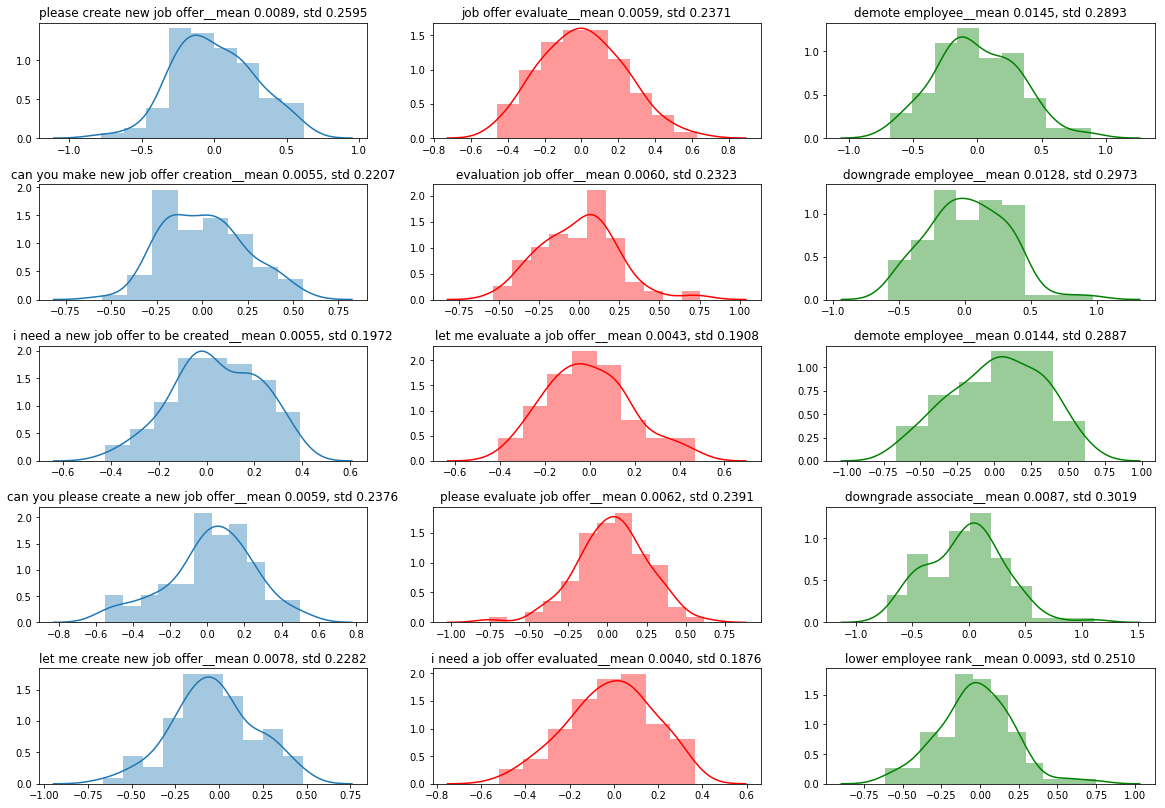

In [245]:
f, axs = plt.subplots(figsize=(20, 14),nrows=len(list_intents_1),ncols=3)
plt.subplots_adjust(hspace = 0.4)
for i,phrase in enumerate(list_intents_1):
    sample, mean, std = get_phrase_dist(phrase)
    sns.distplot(sample, ax=axs[i][0]).set_title(phrase + "__mean {:.4f}, std {:.4f}".format(mean, std))
for i,phrase in enumerate(list_intents_2):
    sample, mean, std = get_phrase_dist(phrase)
    sns.distplot(sample, ax=axs[i][1],color="r").set_title(phrase + "__mean {:.4f}, std {:.4f}".format(mean, std))
for i,phrase in enumerate(list_intents_3):
    sample, mean, std = get_phrase_dist(phrase)
    sns.distplot(sample, ax=axs[i][2],color="g").set_title(phrase + "__mean {:.4f}, std {:.4f}".format(mean, std))

In [489]:
## Plot phrases for given dataset
n_phrase_samples = 5
list_intents = {}
available_intents = ["promote", 
                     #"demote",
                     #"jobOffer.create", 
                     #"jobReferral.evaluate",
                     "personMaritalStatus.update",
                     "personGender.update"]
for name in available_intents:
    phrases = list(dataset.clean_text[dataset.intent == name][0:n_sample])
    list_intents.update({name:phrases})

In [490]:
sentences = [[item for sublist in list(list_intents.values()) for item in sublist]]
elmo.eval()
character_ids = batch_to_ids(sentences)
embeddings = elmo(character_ids)['elmo_representations'][0].squeeze(dim=0)
embeddings_np = embeddings.detach().numpy()
embeddings_np.shape

(24, 1024)

In [491]:
%matplotlib inline
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [492]:
tsne=TSNE(n_components=2,perplexity = 2, method ='exact',verbose=1)
sentences_tsne = tsne.fit_transform(embeddings_np)
sentences_tsne.shape

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 24 / 24
[t-SNE] Mean sigma: 0.984535
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.004392
[t-SNE] Error after 1000 iterations: 0.217954


(24, 2)

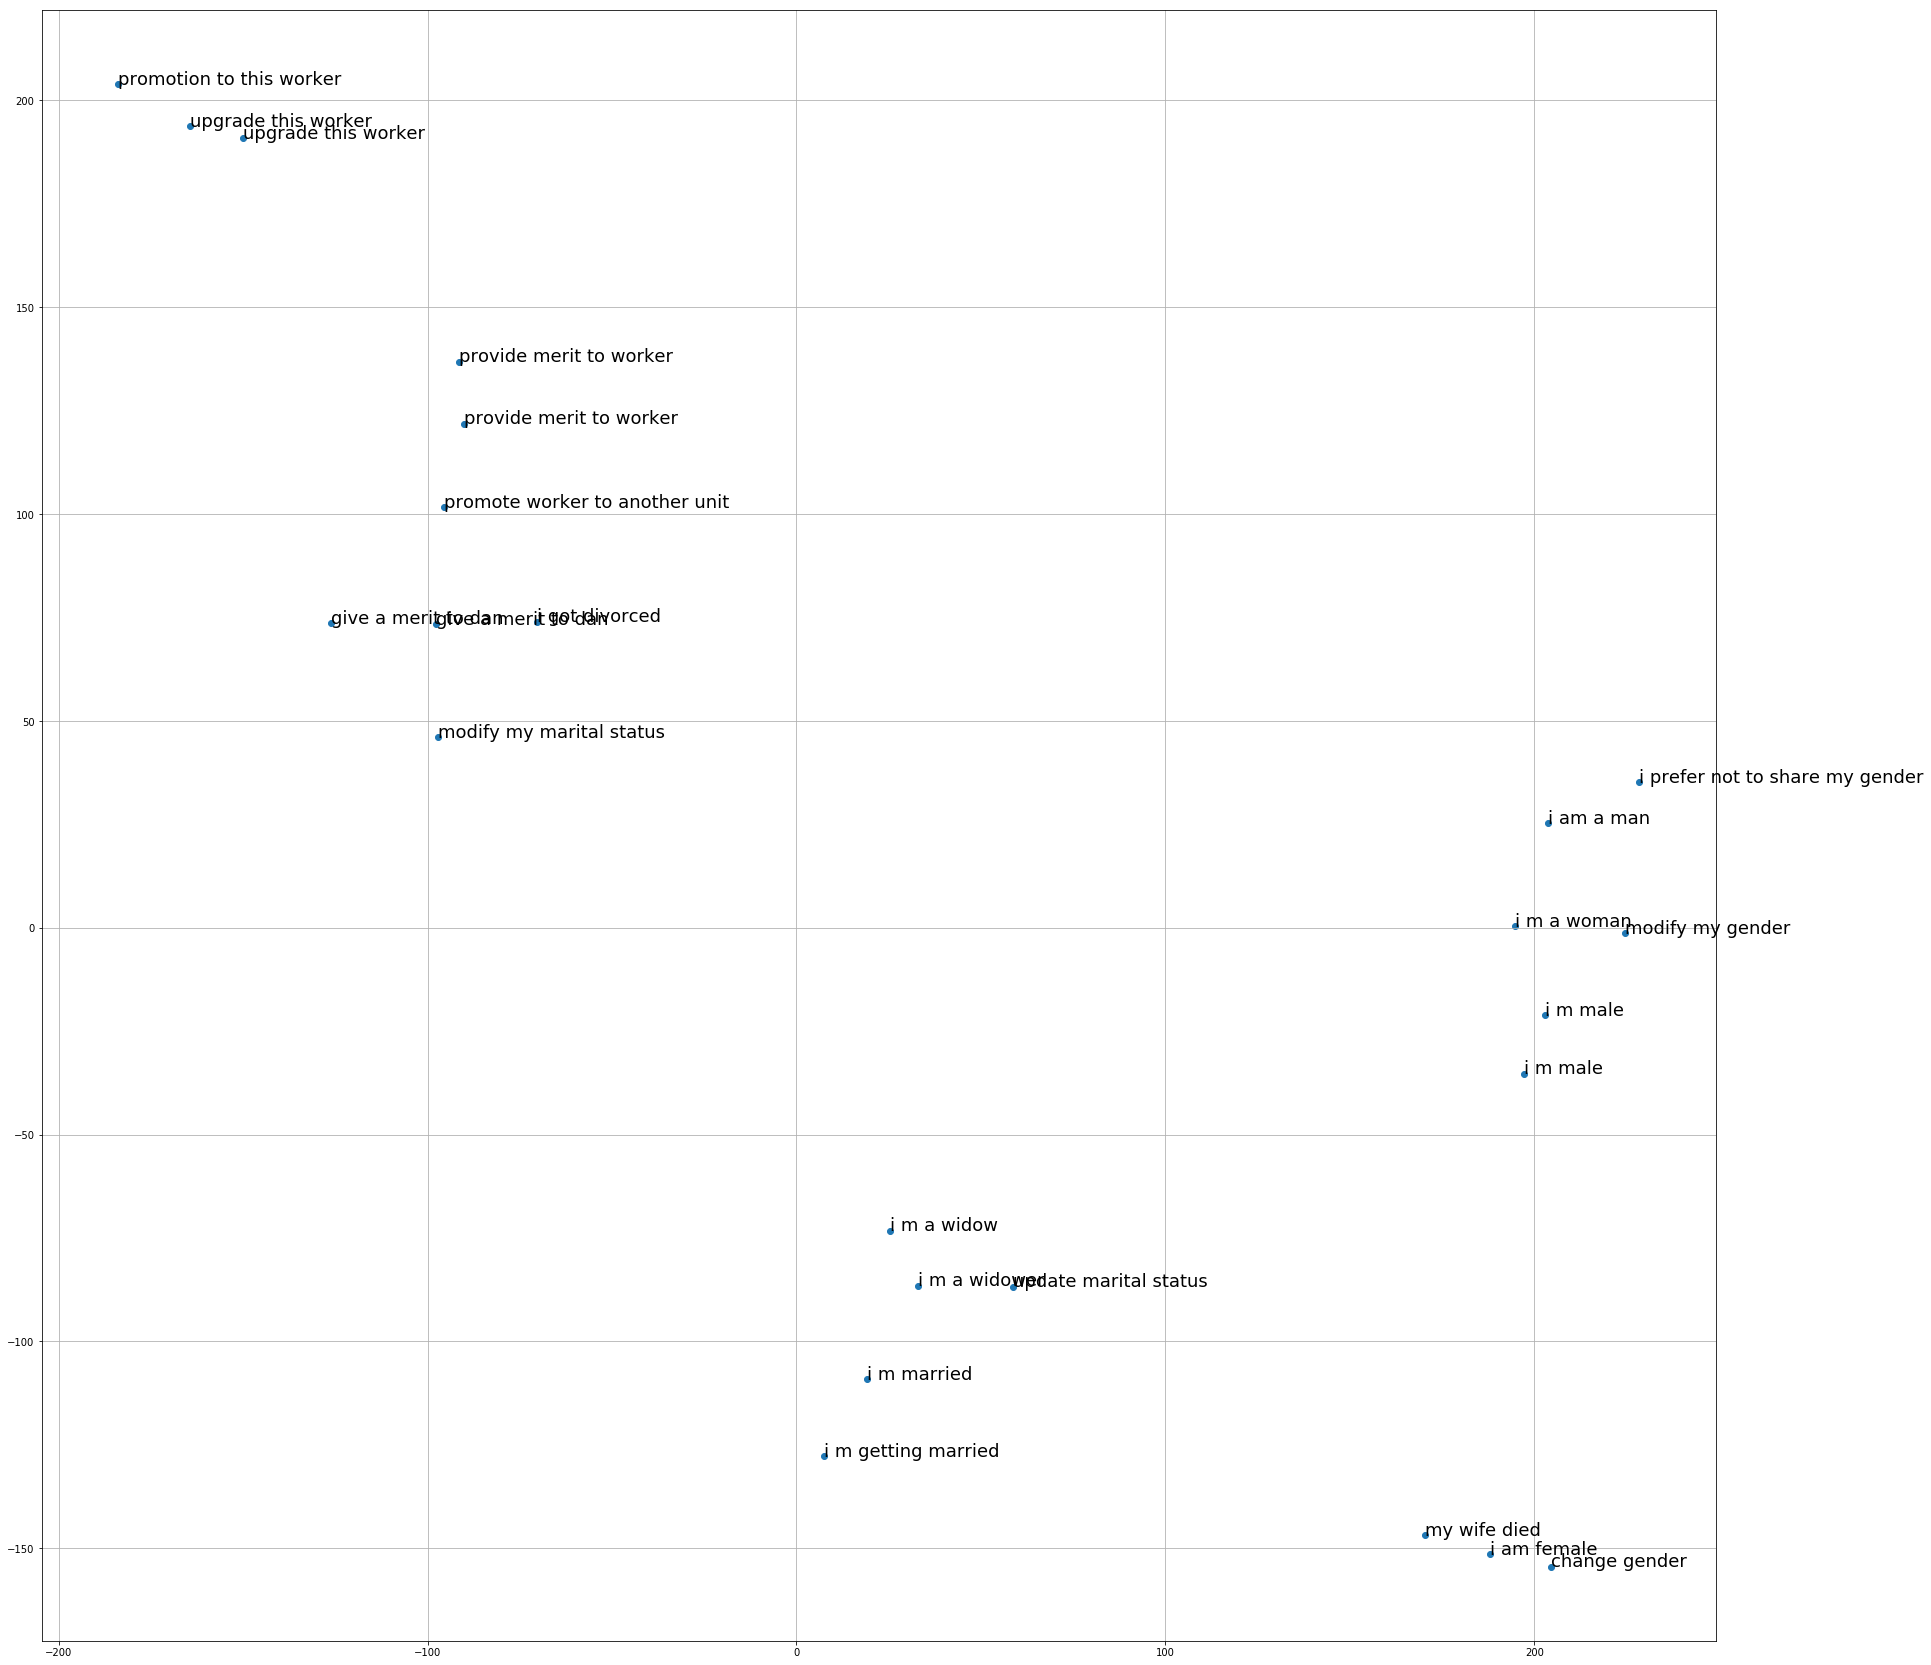

In [493]:
plt.subplots(figsize=(30, 30))
plt.grid()
plt.scatter(sentences_tsne[:,0], sentences_tsne[:,1])
for label, x, y in zip(sentences[0],sentences_tsne[:,0], sentences_tsne[:,1]):
    font = {'size' : 18, 'weight' : 'normal'}
    plt.rc('font', **font)
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')